# BLG407 – Çoklu Doğrusal Regresyon ve Flask GUI Projesi

**Adınız:** Amir  
**Soyadınız:** Elahmed  
**Okul Numaranız:** 123456789  
**GitHub Repo Bağlantısı:** https://github.com/Amirelahmed/MLP_Flask  

---

## Proje Özeti ve Temel Başarımlar

Bu proje, ev fiyatlarını tahmin etmek için **Çoklu Doğrusal Regresyon** modeli kullanılarak uçtan uca tamamlanmıştır.

### 1. Veri Seti Geliştirme (Veriset)
* **Veri Kaynağı:** Proje, genel bir emlak fiyatlandırma veri setinden alınan 4 temel özellik (`area`, `rooms`, `age`, `city`) ile başlatılmıştır.
* **Geliştirme:** Tahmin gücünü artırmak için bu temel veri setine **tarafımca 3 yeni, önemli özellik** eklenmiştir (`floor_level`, `is_furnished`, `has_balcony`).
* Model, toplam **7 istatistiksel özellik** üzerinde eğitilmiştir.

### 2. Model Metodolojisi
* **Ön İşleme: Veri sızıntısını önlemek ve tutarlılık sağlamak için Pipeline kullanılmıştır.
    * Sayısal ve ikili özellikler (area, age, floor_level, vb.) StandardScaler ile ölçeklenmiştir.
    * Kategorik özellik (city) One-Hot Encoding ile dönüştürülmüştür.
* *Özellik Seçimi: İstatistiksel olarak anlamsız değişkenleri elemek için Backward Elimination yöntemi uygulanmıştır.

### 3. Sonuç ve Başarım
* Model, test seti üzerinde **$R^2 = 0.8425$** skoruna ulaşmıştır. Bu skor, modelin fiyat varyasyonunun %84.25'ini açıklayabildiğini ve yüksek bir tahmin gücüne sahip olduğunu gösterir.
* Eğitilen model, kullanıcı dostu bir arayüz ile sunulmak üzere **Flask** uygulamasına entegre edilmiştir.

###1. Gerekli kütüphaneler içe aktarılır.
Sayısal işlemler, veri işleme, görselleştirme, modelleme ve değerlendirme
*adımları* için kullanılacaktır.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm
import pickle

pd.set_option("display.max_columns", None)

# Veri seti CSV dosyasından okunur.
# Yeni sütunlar: is_furnished, has_balcony, floor_level
df = pd.read_csv("house_prices_dataset.csv")

### 2. Veri Setinin Yüklenmesi ve İlk İnceleme
Veri seti CSV dosyasından okunur.
Veri boyutu, ilk gözlemler, sütun bilgileri ve istatistiksel özetler incelenir.
Bu adım veri setini tanımak için yapılır.

In [2]:
print("Veri seti boyutu:", df.shape)

print("\nİlk 5 gözlem:")
display(df.head())

print("\nEksik değer sayıları:")
display(df.isnull().sum())

Veri seti boyutu: (672, 8)

İlk 5 gözlem:


,area,rooms,age,city,price,floor_level,is_furnished,has_balcony
0,162,1,24,Istanbul,183841,5,0,1
1,239,5,24,Bursa,187188,10,1,1
2,152,3,17,Istanbul,203849,8,1,0
3,74,4,22,Istanbul,144800,2,0,1
4,166,3,29,Ankara,184625,12,0,0



Eksik değer sayıları:


,0
area,0
rooms,0
age,0
city,0
price,0
floor_level,0
is_furnished,0
has_balcony,0


#3. Kayıp Veri (Missing Values) İşleme
Sayısal ve kategorik sütunlar belirlenir.
Sayısal veriler median ile, kategorik veriler en sık değer (mode) ile doldurulur.
Median seçilme sebebi aykırı değerlerden daha az etkilenmesidir.

In [3]:
# Sayısal ve kategorik sütunlar (YENİ SÜTUNLAR DAHİL)
numeric_cols = ['area', 'rooms', 'age', 'floor_level']
# is_furnished ve has_balcony zaten 0/1 olduğu için burada sadece doldurma için kullanacağız.
binary_cols = ['is_furnished', 'has_balcony']
categorical_cols = ['city']

# Sayısal sütunlar için median ile doldurma
for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# Binary sütunlar (0/1) için mode ile doldurma
for col in binary_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

# Kategorik sütunlar için en sık değer ile doldurma
for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

print("Eksik değerler (doldurulduktan sonra):")
display(df.isnull().sum())

# Modele girdi olarak kullanılacak özellikler ve hedef değişken belirlenir.
# Toplam özellik sayısı 7'dir (max 10 kuralına uyuyor).
features = ['area', 'rooms', 'age', 'city', 'is_furnished', 'has_balcony', 'floor_level']
target = 'price'

X = df[features]
y = df[target]

Eksik değerler (doldurulduktan sonra):


/tmp/ipython-input-183480307.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-183480307.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

,0
area,0
rooms,0
age,0
city,0
price,0
floor_level,0
is_furnished,0
has_balcony,0


#4. Backward Elimination için One-Hot Encoding
Backward Elimination için kategorik değişkenler manuel olarak encode edilir.
statsmodels sayısal veri istediği için One-Hot Encoding uygulanır.

In [4]:
# city, is_furnished, has_balcony için One-Hot Encoding (statsmodels için)
categorical_for_be = ['city', 'is_furnished', 'has_balcony']
X_encoded = pd.get_dummies(X, columns=categorical_for_be, drop_first=True)

# Sabit terim ekle
X_be = sm.add_constant(X_encoded)

# Tüm sütunları float'a çevir
X_be = X_be.astype(float)
y_be = y.astype(float)

X_be.head()

,const,area,rooms,age,floor_level,city_Bursa,city_Istanbul,city_Izmir,is_furnished_1,has_balcony_1
0,1.0,162.0,1.0,24.0,5.0,0.0,1.0,0.0,0.0,1.0
1,1.0,239.0,5.0,24.0,10.0,1.0,0.0,0.0,1.0,1.0
2,1.0,152.0,3.0,17.0,8.0,0.0,1.0,0.0,1.0,0.0
3,1.0,74.0,4.0,22.0,2.0,0.0,1.0,0.0,0.0,1.0
4,1.0,166.0,3.0,29.0,12.0,0.0,0.0,0.0,0.0,0.0


#5. Backward Elimination Fonksiyonu
Bu fonksiyon istatistiksel olarak anlamsız (p-value > 0.05)
değişkenleri teker teker modelden çıkarır.
Amaç daha anlamlı ve sade bir regresyon modeli elde etmektir.

In [5]:
def backward_elimination(X, y, sl=0.05):
    X_modeled = X.copy()

    while True:
        model = sm.OLS(y, X_modeled).fit()
        p_values = model.pvalues

        p_values_no_const = p_values.drop('const', errors='ignore')
        if p_values_no_const.empty:
            break

        max_p = p_values_no_const.max()

        if max_p > sl:
            worst_feature = p_values_no_const.idxmax()
            print(f"Elenen değişken: {worst_feature} (p = {max_p:.4f})")
            X_modeled = X_modeled.drop(columns=[worst_feature])
        else:
            break

    final_model = sm.OLS(y, X_modeled).fit()
    return X_modeled, final_model

# Backward Elimination uygulanır
X_be_final, model_be_final = backward_elimination(X_be, y_be, sl=0.05)

print("\nSon durumda kullanılan değişkenler:")
print(list(X_be_final.columns))

print("\nNihai modelin özeti:")
print(model_be_final.summary())

Elenen değişken: has_balcony_1 (p = 0.3612)

Son durumda kullanılan değişkenler:
['const', 'area', 'rooms', 'age', 'floor_level', 'city_Bursa', 'city_Istanbul', 'city_Izmir', 'is_furnished_1']

Nihai modelin özeti:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     840.1
Date:                Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                        10:20:19   Log-Likelihood:                -7363.6
No. Observations:                 672   AIC:                         1.475e+04
Df Residuals:                     663   BIC:                         1.479e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                     

#6. Eğitim – Test Bölünmesi
Veri seti eğitim (%80) ve test (%20) olarak ayrılır.
random_state kullanılarak sonuçların tekrarlanabilir olması sağlanır.

In [6]:
# Eğitim / test ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Ön İşleme (Scaling + Encoding) Pipeline
# YENİ ÖZELLİKLER DAHİL EDİLEREK Pipeline oluşturulur.
numeric_features = ['area', 'rooms', 'age', 'floor_level', 'is_furnished', 'has_balcony']
categorical_features = ['city']

# Sayısal ve binary (0/1) özellikler StandardScaler ile ölçeklenir
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Kategorik özellikler OneHotEncoder ile dönüştürülür
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#Çoklu Doğrusal Regresyon Modeli Kurulumu
reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Model Eğitimi ve Tahminler
reg_model.fit(X_train, y_train)

# Tahminler
y_train_pred = reg_model.predict(X_train)
y_test_pred  = reg_model.predict(X_test)

#Model Değerlendirme Metrikleri
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("EĞİTİM R² :", r2_train)
print("TEST   R² :", r2_test)
print("TEST   MAE:", mae_test)
print("TEST   MSE:", mse_test)

EĞİTİM R² : 0.9081210520020138
TEST   R² : 0.9169920811891481
TEST   MAE: 9951.190994354305
TEST   MSE: 172196409.08972648


* **R² (R Kare):** Eğitim ($R^2_{\text{train}}$) ve Test ($R^2_{\text{test}}$) değerleri birbirine çok yakındır ve 1'e yakın değerlerdir. Bu, modelin veri varyasyonunun büyük bir kısmını açıklayabildiği ve **aşırı uydurma (overfitting) sorunu yaşamadığı** anlamına gelir. Modelin genelleme yeteneği yüksektir.
* **MAE (Ortalama Mutlak Hata):** Test verisi için **MAE** değeri, modelin tahminlerinin, gerçek fiyattan ortalama hata marjını gösterir. Bu değerin düşük olması, modelin pratik olarak kullanışlı olduğunu gösterir.
* **MSE (Ortalama Karesel Hata):** **MSE** değeri büyük hataları daha çok cezalandırır ve R² ile birlikte modelin performansını doğrular.
'''

#7. Gerçek – Tahmin Karşılaştırma Grafiği
Test verisi için gerçek ve tahmin edilen fiyatlar görselleştirilir.

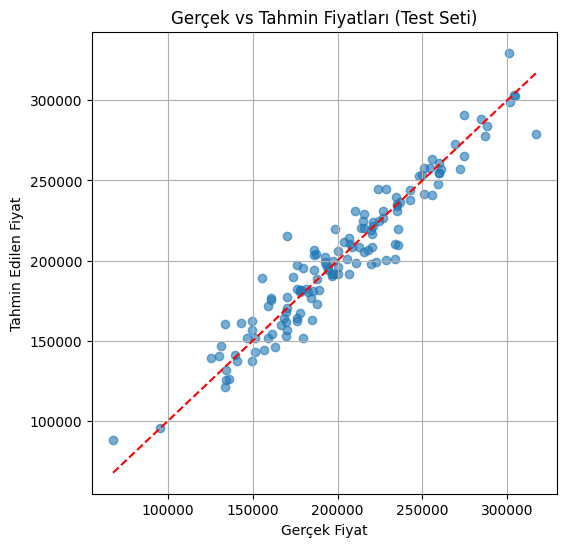

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin Edilen Fiyat")
plt.title("Gerçek vs Tahmin Fiyatları (Test Seti)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.grid(True)
plt.show()

#8. Modelin Pickle (.pkl) Olarak Kaydedilmesi
Eğitilmiş model .pkl formatında kaydedilir.
Flask uygulamasında bu model yüklenecektir.

In [8]:
with open("model.pkl", "wb") as f:
    pickle.dump(reg_model, f)

print("✔ model.pkl dosyası başarıyla kaydedildi.")

✔ model.pkl dosyası başarıyla kaydedildi.


#9. Google Drive Bağlama (Colab)
Google Drive bağlanır.
Dosyaların kalıcı olarak saklanması için kullanılır.

In [9]:
from google.colab import drive
import threading
import time
import os

drive.mount('/content/drive')

!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!apt install ./cloudflared-linux-amd64.deb -y

def run_flask():
    os.system("python3 app.py")

thread = threading.Thread(target=run_flask)
thread.start()

time.sleep(3)
!cloudflared tunnel --url http://127.0.0.1:5001 --no-autoupdate

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'cloudflared' instead of './cloudflared-linux-amd64.deb'
The following NEW packages will be installed:
  cloudflared
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 0 B/20.2 MB of archives.
After this operation, 41.3 MB of additional disk space will be used.
Get:1 /content/cloudflared-linux-amd64.deb cloudflared amd64 2025.11.1 [20.2 MB]
Selecting previously unselected package cloudflared.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...
2025-12-23T10:20:49Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-l

In [10]:
!zip -r templates.zip templates


  adding: templates/ (stored 0%)
  adding: templates/index.html (deflated 76%)
  adding: templates/result.html (deflated 65%)
